In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# read cleaned dataframe that was saved in csv file beforehand
data = pd.read_csv("./files/data_clean.csv")
df = data.copy()
display(df.head())
df.shape

,date,year,gold,silver,platinum,coal_monthly,n_gas,oil,euro,gb_pound,dowjones_industrial,dowjones_transport,nasdaq,snp,southern_copper,rio_tinto,royal_gold,newmont,agnico_mines
0,1997-10-01,1997,333.5,5.16,1.46,37.15,3.12,21.05,1.10,1.62,8015.5,3203.6,1102.06,955.41,3.04,16.25,8.75,44.44,9.94
1,1997-10-02,1997,331.2,5.16,1.48,37.15,3.11,21.77,1.11,1.62,8027.5,3227.8,1112.84,960.46,3.02,16.22,8.56,44.88,9.81
2,1997-10-03,1997,334.6,5.28,1.50,37.15,3.12,22.76,1.12,1.62,8038.6,3207.8,1124.44,965.03,3.03,16.16,8.56,44.94,10.06
3,1997-10-06,1997,332.3,5.20,1.45,37.15,2.98,21.93,1.11,1.62,8100.2,3250.0,1125.93,972.69,3.01,16.22,8.25,44.25,9.81
4,1997-10-07,1997,331.2,5.19,1.41,37.15,2.88,21.96,1.11,1.62,8178.3,3281.2,1140.74,983.12,3.04,16.12,8.38,44.25,9.50


(5281, 19)

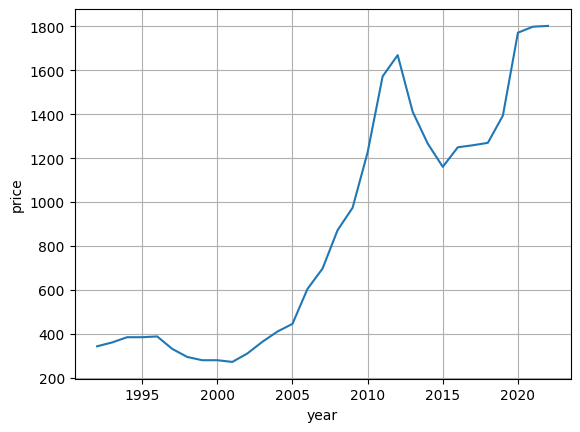

In [26]:
# check the gold growth graph
gold = pd.read_csv("./files/gold price full.csv")
sns.lineplot(x = "year", y = "price", data = gold.pivot_table(index = "year", aggfunc = {"price":"mean"}))
plt.grid()
plt.show()

In [27]:
# the part where the price sinks greatly after 2012 greatly reduces the accuracy of the prediction. 
# for the first try, we take only the prices before the fall as our data.
display(gold.shape)
gold = gold[gold["year"] < 2015]
display(gold.shape)
# see the peak price before the fall
gold[gold["price"] == gold["price"].max()]

(8000, 3)

(5921, 3)

,date,price,year
5057,2011-09-05,1901.34,2011


In [28]:
# take only prices from beginning to that peak price in 2011
df =df[df["date"] <= "2011-09-05"]

making a csv file for tableau illustration

In [29]:
# days_ahead = 4
# data_pivot = data.pivot_table(index = ["year"], aggfunc="mean").reset_index()
# data_pivot.to_csv("data clean pivot.csv")
# df_gold = data_pivot[["year","gold"]].copy()
# df_ngold = data_pivot.drop("gold", axis = 1)
# df_ngold = df_ngold.shift(days_ahead, axis = 0)
# data_shift = [df_gold, df_ngold]
# data_shift = pd.concat(data_shift, axis = 1)
# # data_shift = data_shift.iloc[days_ahead:]
# data_shift.to_csv("data clean shift.csv")

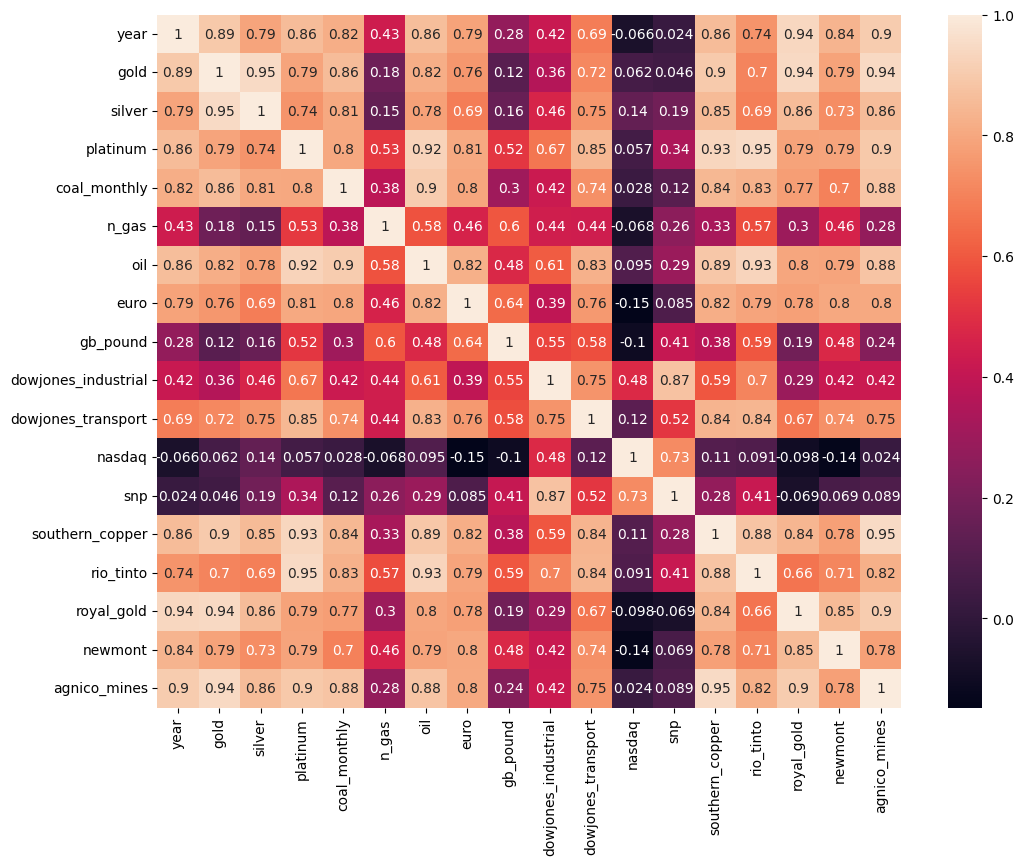

In [30]:
# heatmap
plt.figure(figsize=(12, 9))
correlations_matrix = df.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

making a csv file for tableau illustration

In [31]:
# df_pick = df[["year","gold","silver","coal_monthly","oil","southern_copper","agnico_mines"]]
# df_pick = df_pick.pivot_table(index = "year", aggfunc = "mean").reset_index()
# df_pick_year = df_pick[["year"]]
# df_pick_nyear = df_pick.drop("year", axis = 1)
# transformer_2 = MinMaxScaler().fit(df_pick_nyear)
# df_pick_scaled = transformer_2.transform(df_pick_nyear)
# df_pick_scaled = pd.DataFrame(df_pick_scaled)
# df_pick = pd.concat([df_pick_year, df_pick_scaled], axis = 1)
# df_pick.columns = ["year","gold","silver","coal_monthly","oil","southern_copper","agnico_mines"]
# df_pick.to_csv("./files/picked data.csv")
# df_pick.head()

In [179]:
# import everything that we need
# i forgot which one I used and which one I didn't. this might need to be sorted again later.
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### FUNCTION TO SHIFT DATA:
we shift the all-prices beside gold to [n] days ahead, <br>
so that the all-prices at day [x] will be on the same row <br>
as the gold price at day [x+n]

In [33]:
def shift_price(df, days_ahead):
    dftry = df.copy()
    dftry = df.reset_index(drop = True)
    dftry_gold = dftry[["date","gold"]].copy()
    dftry_ngold = dftry.drop("gold", axis = 1)
    # for i in dftry_ngold.columns:
    #     dftry_ngold[i] = dftry_ngold[i].shift(+predict_range)
    dftry_ngold = dftry_ngold.shift(days_ahead, axis = 0)
    dftry = [dftry_gold, dftry_ngold]
    dftry = pd.concat(dftry, axis = 1)
    dftry = dftry.iloc[days_ahead:]
    new = dftry.iloc[-days_ahead:]
    data = dftry.iloc[0:-days_ahead]
    return new, data

### FUNCTION MAKE PIVOT TABLE
I needed this part only at the beginning, where I tried various things to try to get a decent R2 score. <br>
The end result didn't use this function.

In [34]:
def to_pivot_table(new, data):
    new = new.pivot_table(index = ["year","month"], aggfunc="mean").reset_index()
    data = data.pivot_table(index = ["year","month"], aggfunc="mean").reset_index()
    return new, data

### FUNCTION LINREG
takes xtrain, xtest, xnew, ytrain, ytest, ynew <br>
gives back float(r2_train), float(r2_test), float(r2_new), and<br> 
predictions for [n] days ahead as a single-column dataframe

In [35]:
def linreg_predict(xtrain, xtest , xnew, ytrain, ytest, ynew):
    regr = linear_model.LinearRegression()
    regr.fit(xtrain, ytrain)

    pred_train = regr.predict(xtrain)
    r2_train = r2_score(ytrain, pred_train)

    pred_test = regr.predict(xtest)
    r2_test = r2_score(ytest, pred_test)
    
    pred_new = regr.predict(xnew)
    r2_new = r2_score(ynew, pred_new)

    pred_new = pd.DataFrame(pred_new, columns = ["linreg"])
    pred_new = round(pred_new,2)

    return r2_train, r2_test, r2_new, pred_new

### FUNCTION MULTI LAYER PERCEPTRON (MLP)

In [36]:
def mlp_predict(xtrain, xtest, xnew, ytrain, ytest, ynew):
    regr = MLPRegressor(random_state = 1, max_iter = 500)
    regr.fit(xtrain, ytrain)

    r2_train = regr.score(xtrain, ytrain)
    r2_test = regr.score(xtest, ytest)
    r2_new = regr.score(xnew, ynew)

    pred_new = regr.predict(xnew)
    pred_new = pd.DataFrame(pred_new, columns = ["mlp"])
    pred_new = round(pred_new,2)
    
    return r2_train, r2_test, r2_new, pred_new

### FUNCTION K-NEAREST NEIGHBOR REGRESSOR (KNN)

In [37]:
def knn_predict(xtrain, xtest, xnew, ytrain, ytest, ynew):
    regr = KNeighborsRegressor(n_neighbors=5, p = 1)
    regr.fit(xtrain, ytrain)

    r2_train = regr.score(xtrain, ytrain)
    r2_test = regr.score(xtest, ytest)
    r2_new = regr.score(xnew, ynew)

    pred_new = regr.predict(xnew)
    pred_new = pd.DataFrame(pred_new, columns = ["knn"])
    pred_new = round(pred_new,2)
    
    return r2_train, r2_test, r2_new, pred_new

### FUNCTION ADABOOST REGRESSOR (ABR)

In [38]:
def abr_predict(xtrain, xtest, xnew, ytrain, ytest, ynew):
    dtr = DecisionTreeRegressor(max_depth = 1)
    regr = AdaBoostRegressor(n_estimators = 50, base_estimator = dtr, learning_rate = 1)
    regr.fit(xtrain, ytrain)
    
    pred_train = regr.predict(xtrain)
    r2_train = metrics.r2_score(ytrain, pred_train)

    pred_test = regr.predict(xtest)
    r2_test = metrics.r2_score(ytest, pred_test)

    pred_new = regr.predict(xnew)
    r2_new = metrics.r2_score(ynew, pred_new)

    pred_new = pd.DataFrame(pred_new, columns = ["ada_boost"])
    pred_new = round(pred_new,2)

    return r2_train, r2_test, r2_new, pred_new

### FUNCTION RANDOM FOREST REGRESSOR

In [39]:
def r_forest_predict(xtrain, xtest, xnew, ytrain, ytest, ynew):
    regr = RandomForestRegressor(max_depth = 2, random_state = 0)
    regr.fit(xtrain, ytrain)

    r2_train = regr.score(xtrain, ytrain, sample_weight = None)
    r2_test = regr.score(xtest, ytest, sample_weight = None)
    r2_new = regr.score(xnew, ynew, sample_weight = None)

    pred_new = regr.predict(xnew)
    pred_new = pd.DataFrame(pred_new, columns = ["random_forest"])
    pred_new = round(pred_new,2)

    return r2_train, r2_test, r2_new, pred_new

### FUNCTION THAT RUNS ALL PREDICTION FUNCTIONS

In [40]:
def run_predictions(df,days_ahead, t_size, to_drop, target, pivot_table, shift_data):
    df["month"] = pd.DatetimeIndex(df["date"]).month
    new = df.iloc[-days_ahead:]
    data = df.iloc[0:-days_ahead]

    if shift_data:
        new, data = shift_price(df, days_ahead)
    if pivot_table:
        new, data = to_pivot_table(new, data)

    X = data.drop(to_drop, axis = 1)
    y = data[target].copy()
    X_new = new.drop(to_drop, axis = 1)
    y_new = new[target].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=66)
    
    num_train = X_train.select_dtypes(np.number)
    num_test = X_test.select_dtypes(np.number)
    num_new = X_new.select_dtypes(np.number)
    
    transformer = MinMaxScaler().fit(num_train)
    X_train_scaled = transformer.transform(num_train)
    X_test_scaled = transformer.transform(num_test)
    X_new_scaled = transformer.transform(num_new)
    
    a1,b1,c1,d1 = linreg_predict(X_train_scaled, X_test_scaled, X_new_scaled, y_train, y_test, y_new)
    a2,b2,c2,d2 = mlp_predict(X_train_scaled, X_test_scaled, X_new_scaled, y_train, y_test, y_new)
    a3,b3,c3,d3 = knn_predict(X_train_scaled, X_test_scaled, X_new_scaled, y_train, y_test, y_new)
    a4,b4,c4,d4 = abr_predict(X_train_scaled, X_test_scaled, X_new_scaled, y_train, y_test, y_new)
    a5,b5,c5,d5 = r_forest_predict(X_train_scaled, X_test_scaled, X_new_scaled, y_train, y_test, y_new)

    return a1,b1,c1,d1,a2,b2,c2,d2,a3,b3,c3,d3,a4,b4,c4,d4,a5,b5,c5,d5
    # a,b,c are float numbers, while d are single column dataframes containing predictions
    # the shape of the d is equal to the.... i forgot what i wanted to write here

### FUNCTION TO PRESERVE THE RESULTS IN DATAFRAME

shutting down all warnings

In [41]:
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
pd.options.mode.chained_assignment = None

In [42]:
def get_result(t_size, pivot_date, df, columns_to_drop, target_column, days_ahead, shift_data):
    # preparing lists to create dataframe containing r-scores for all methods, as well as the data size being used
    new_data_size = []
    lr_train = []
    lr_test = []
    lr_new = []
    mlp_train = []
    mlp_test = []
    mlp_new = []
    knn_train = []
    knn_test = []
    knn_new = []
    abr_train = []
    abr_test = []
    abr_new = []
    r_forest_train = []
    r_forest_test = []
    r_forest_new = []
    pred_linreg = []
    pred_mlp = []
    pred_knn = []
    pred_abr = []
    pred_r_forest = []
    res = pd.DataFrame()
    new_scores = pd.DataFrame()
    best_score = []
    
    for i in days_ahead:
        new_data_size.append(i)
        a1,b1,c1,d1,a2,b2,c2,d2,a3,b3,c3,d3,a4,b4,c4,d4,a5,b5,c5,d5 = run_predictions(df, i, t_size, columns_to_drop, target_column, pivot_date, shift_data)
        lr_train.append(a1)
        lr_test.append(b1)
        lr_new.append(c1)
        mlp_train.append(a2)
        mlp_test.append(b2)
        mlp_new.append(c2)
        knn_train.append(a3)
        knn_test.append(b3)
        knn_new.append(c3)
        abr_train.append(a4)
        abr_test.append(b4)
        abr_new.append(c4)
        r_forest_train.append(a5)
        r_forest_test.append(b5)
        r_forest_new.append(c5)
        pred_linreg.append(d1)
        pred_mlp.append(d2)
        pred_knn.append(d3)
        pred_abr.append(d4)
        pred_r_forest.append(d5)
        best_score.extend([c1,c2,c3,c4,c5])
    
    res["new_data_size"] = new_data_size
    res["linreg_train"] = lr_train
    res["linreg_test"] = lr_test
    res["linreg_new"] = lr_new
    res["mlp_train"] = mlp_train
    res["mlp_test"] = mlp_test
    res["mlp_new"] = mlp_new
    res["knn_train"] = knn_train
    res["knn_test"] = knn_test
    res["knn_new"] = knn_new
    res["abr_train"] = abr_train
    res["abr_test"] = abr_test
    res["abr_new"] = abr_new
    res["random_forest_train"] = r_forest_train
    res["random_forest_test"] = r_forest_test
    res["random_forest_new"] = r_forest_new
    
    # make some sound to notify when the process finishes. this could take like until 45 mins, 
    # depending on the iteration
    import winsound
    import time
    do = 500
    duration = 900
    for i in range(3):
        winsound.Beep(do, duration)
        time.sleep(.2)

    return res

### FUNCTION TO PRINT BEST RESULTS

In [46]:
def display_all_max_r2(res):
    print("Linear Regression")
    print("highest prediction score in Linear Regression:", res.linreg_new.max())
    display(res.loc[res.linreg_new == res.linreg_new.max(), ["new_data_size","linreg_train","linreg_test","linreg_new"]])
    print("\n\nMulti-Layer-Perceptron")
    print("highest prediction score in Multi-Layer Perceptron:", res.mlp_new.max())
    display(res.loc[res.mlp_new == res.mlp_new.max(), ["new_data_size","mlp_train","mlp_test","mlp_new"]])
    print("\n\nK-Nearest Neighbors")
    print("highest prediction score in K-Nearest Neighbors:", res.knn_new.max())
    display(res.loc[res.knn_new == res.knn_new.max(), ["new_data_size","knn_train","knn_test","knn_new"]])
    print("\n\nAdaBoost Regressor")
    print("highest prediction score in AdaBoost Regressor:", res.abr_new.max())
    display(res.loc[res.abr_new == res.abr_new.max(), ["new_data_size","abr_train","abr_test","abr_new"]])
    print("\n\nRandom Forest")
    print("highest prediction score in Random Forest:", res.random_forest_new.max())
    display(res.loc[res.random_forest_new == res.random_forest_new.max(), ["new_data_size","random_forest_train","random_forest_test","random_forest_new"]])
    

### RUN THE FUNCTION

beware. this takes like 16-20 mins. because it's iterating the prediction process through different data sizes<br>(see variable "days_ahead")

In [45]:
t_size = 0.1
pivot_date = False
shift_data = True
to_drop = ["gold"]
target = ["gold"]
days_ahead = range(10,1801,10)
res= get_result(t_size, pivot_date, df, to_drop, target, days_ahead, shift_data)
display_all_max_r2(res)

Linear Regression
highest prediction score in Linear Regression: 0.803258078641417


,new_data_size,linreg_train,linreg_test,linreg_new
132,1330,0.961361,0.946873,0.803258




MLP
highest prediction score in Multi-Layer Perceptron: 0.8353625327995614


,new_data_size,mlp_train,mlp_test,mlp_new
113,1140,0.852212,0.868568,0.835363




KNN
highest prediction score in K-Nearest Neighbors: 0.061054557524779285


,new_data_size,knn_train,knn_test,knn_new
0,10,0.999548,0.999383,0.061055




ABR
highest prediction score in ABR: -1.4893132534919644


,new_data_size,abr_train,abr_test,abr_new
76,770,0.760519,0.787601,-1.489313




Random Forest
highest prediction score in r_forest: -1.0029472957372305


,new_data_size,random_forest_train,random_forest_test,random_forest_new
81,820,0.944174,0.954156,-1.002947


In [47]:
display_all_max_r2(res)

Linear Regression
highest prediction score in Linear Regression: 0.803258078641417


,new_data_size,linreg_train,linreg_test,linreg_new
132,1330,0.961361,0.946873,0.803258




Multi-Layer-Perceptron
highest prediction score in Multi-Layer Perceptron: 0.8353625327995614


,new_data_size,mlp_train,mlp_test,mlp_new
113,1140,0.852212,0.868568,0.835363




K-Nearest Neighbors
highest prediction score in K-Nearest Neighbors: 0.061054557524779285


,new_data_size,knn_train,knn_test,knn_new
0,10,0.999548,0.999383,0.061055




AdaBoost Regressor
highest prediction score in AdaBoost Regressor: -1.4893132534919644


,new_data_size,abr_train,abr_test,abr_new
76,770,0.760519,0.787601,-1.489313




Random Forest
highest prediction score in Random Forest: -1.0029472957372305


,new_data_size,random_forest_train,random_forest_test,random_forest_new
81,820,0.944174,0.954156,-1.002947


In [42]:
# from the result above, we can see that the MLP prediction with new_data_size of 1140 makes the best prediction
# new_data_size of 1140 means it predicts to 1140 days ahead.
# so it's predicting gold prices for like 3 years ahead an a few days more

In [142]:
# now we try to run the function again to get the predicted price.
# this time without looping but only using days_ahead = 1140 instead
t_size = 0.1
pivot_date = False
shift_data = True
to_drop = ["gold"]
target = ["gold"]
days_ahead = 1140
a1,b1,c1,d1,a2,b2,c2,d2,a3,b3,c3,d3,a4,b4,c4,d4,a5,b5,c5,d5 = run_predictions(df, days_ahead, t_size, to_drop, target, pivot_date, shift_data)
# a: train score, b: test score, c: new data score, d: prediction results
# 1: linreg, 2: mlp, 3: KNN, 4: adaboost, 5: random forest

### COMPARING REAL vs PREDICTED PRICE

In [143]:
days_ahead = 1140
target = ["gold"]
# since we want to get the prediction result from mlp, we get the d2
display(d2.head())
# and now compare it to the real gold prices from new_data
new, data = shift_price(df, days_ahead)
# we just use the "new" part and not the "data" part here
y_new = new[target].copy().reset_index().drop("index", axis = 1)
display(y_new.head())
display(d2.shape)
display(y_new.shape)

,mlp
0,707.53
1,714.73
2,730.79
3,731.47
4,744.59


,gold
0,683.2
1,683.9
2,674.2
3,680.1
4,680.6


(1140, 1)

(1140, 1)

In [174]:
new.head()

,date,gold,date,year,silver,platinum,coal_monthly,n_gas,oil,euro,...,dowjones_industrial,dowjones_transport,nasdaq,snp,southern_copper,rio_tinto,royal_gold,newmont,agnico_mines,month
2492,2007-04-24,683.2,2002-12-10,2002.0,4.58,7.50,26.25,4.64,27.74,1.01,...,8574.26,2353.38,1033.07,904.45,2.42,19.29,20.54,26.14,12.60,12.0
2493,2007-04-25,683.9,2002-12-11,2002.0,4.63,7.50,26.25,4.71,27.40,1.01,...,8589.14,2348.06,1036.34,904.96,2.42,19.44,21.24,27.00,12.69,12.0
2494,2007-04-26,674.2,2002-12-12,2002.0,4.65,7.25,26.25,5.09,28.01,1.02,...,8538.40,2336.46,1039.95,901.58,2.43,19.43,22.60,28.11,13.73,12.0
2495,2007-04-27,680.1,2002-12-13,2002.0,4.74,7.19,26.25,5.28,28.44,1.02,...,8433.71,2318.47,1005.85,889.48,2.36,19.40,22.28,29.00,14.02,12.0
2496,2007-04-30,680.6,2002-12-16,2002.0,4.70,7.31,26.25,5.34,30.10,1.02,...,8627.40,2359.00,1042.44,910.40,2.43,19.98,22.57,29.10,14.37,12.0


In [185]:
df_pick = new[["gold","silver","platinum","coal_monthly","oil","euro","southern_copper","agnico_mines","dowjones_transport"]]
transformer_2 = MinMaxScaler().fit(df_pick)
df_pick_scaled = transformer_2.transform(df_pick)
df_pick_scaled = pd.DataFrame(df_pick_scaled)
df_pick_scaled.columns = ["gold_scaled","silver","platinum","coal_monthly","oil","euro","southern_copper","agnico_mines","dowjones_transport"]
display(df_pick_scaled.shape)
df_pick_scaled.head()

(1140, 9)

,gold_scaled,silver,platinum,coal_monthly,oil,euro,southern_copper,agnico_mines,dowjones_transport
0,0.032254,0.019905,0.049404,0.031618,0.048272,0.000000,0.003514,0.076682,0.125990
1,0.032811,0.024645,0.049404,0.031618,0.041707,0.000000,0.003514,0.079247,0.124360
2,0.025104,0.026540,0.040886,0.031618,0.053485,0.028571,0.003905,0.108894,0.120806
3,0.029792,0.035071,0.038842,0.031618,0.061788,0.028571,0.001171,0.117161,0.115294
4,0.030189,0.031280,0.042930,0.031618,0.093841,0.028571,0.003905,0.127138,0.127712


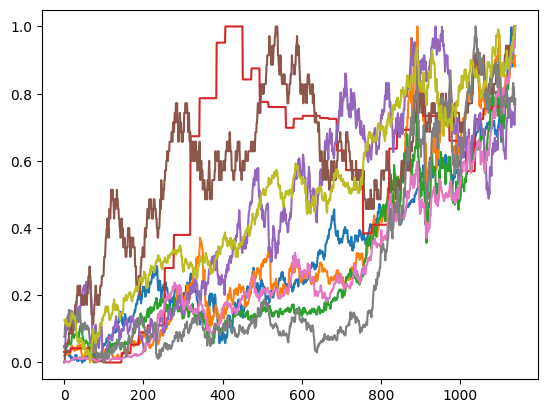

In [186]:
plt.plot(df_pick_scaled)

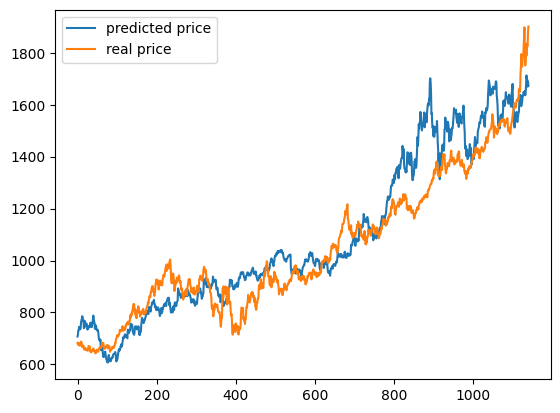

In [144]:
plt.plot(d2.mlp, label = "predicted price")
plt.plot(y_new, label = "real price")
plt.legend(loc="upper left")
plt.show()

### NEXT STEP: MAKING BUY/SELL DECISIONS

In [145]:
def see_trends(df, col, timerange):
    # get price prediction as list
    price = df[col].tolist()
    # price_up_trend shows how many day intervals in average does the price go up
    price_up_trend = []
    price_down_trend = []
    # up is a bool whether the price on that day goes up or not
    up = []
    # diff is the difference of price from today compared to yesterday
    diff = []
    price_up = 0
    price_down = 0
    for i in range(len(price)):
        try:
            if i == 0:
                diff.append(0)
                up.append(False)
            else:
                if (i != 0) & (price[i] >= price[i-1]):
                    price_up +=1
                    up.append(True)
                    price_down_trend.append(price_down)
                    price_down = 0
                elif (i != 0) & (price[i] < price[i-1]):
                    price_down += 1
                    up.append(False)
                    price_up_trend.append(price_up)
                    price_up = 0
                diff.append(price[i] - price[i-1])
        except:
            up.append(False)
            diff.append(0)
            
    df["price_goes_up"] = up
    df["delta_price"] = diff
    display(df["price_goes_up"].value_counts())
    # this is the average days interval where price starts to go up again
    price_up_trend_mean = np.mean(price_up_trend)
    price_down_trend_mean = np.mean(price_down_trend)
    print("price goes up every",round(price_up_trend_mean,1), timerange)
    print("price goes down every",round(price_down_trend_mean,1),timerange)
    display(df.head())
    return df

In [146]:
# remember that our data ends on 2011-09-05. Now we want to give date column to our predicted prices.
date_col = pd.date_range(start = "2011-09-06", periods = 1140)
d2["date"] = date_col
timerange = "days"
d2 = see_trends(d2, "mlp", timerange)

True     616
False    524
Name: price_goes_up, dtype: int64

price goes up every 1.2 days
price goes down every 0.8 days


,mlp,date,price_goes_up,delta_price
0,707.53,2011-09-06,False,0.00
1,714.73,2011-09-07,True,7.20
2,730.79,2011-09-08,True,16.06
3,731.47,2011-09-09,True,0.68
4,744.59,2011-09-10,True,13.12


price goes up in average every 1.2 days. this value doesnt really make sense, because it is basically <br>
like saying that there's roughly 50% chance on each day for the price to go up, <br>
and also 50% chance for the price to go down on that day.

### the ones starting with "d2" is the data used more in python, whereas <br>
### the ones starting with "d" was made for tableau. 
### d is basically the same as d2, only it has more columns from other commodities for tableau purpose

In [187]:
# predicted and actual price in a dataframe
d = pd.concat([d2, y_new, df_pick_scaled], axis = 1)
d.head()


,mlp,date,price_goes_up,delta_price,year,month,gold,gold_scaled,silver,platinum,coal_monthly,oil,euro,southern_copper,agnico_mines,dowjones_transport
0,707.53,2011-09-06,False,0.00,2011,9,683.2,0.032254,0.019905,0.049404,0.031618,0.048272,0.000000,0.003514,0.076682,0.125990
1,714.73,2011-09-07,True,7.20,2011,9,683.9,0.032811,0.024645,0.049404,0.031618,0.041707,0.000000,0.003514,0.079247,0.124360
2,730.79,2011-09-08,True,16.06,2011,9,674.2,0.025104,0.026540,0.040886,0.031618,0.053485,0.028571,0.003905,0.108894,0.120806
3,731.47,2011-09-09,True,0.68,2011,9,680.1,0.029792,0.035071,0.038842,0.031618,0.061788,0.028571,0.001171,0.117161,0.115294
4,744.59,2011-09-10,True,13.12,2011,9,680.6,0.030189,0.031280,0.042930,0.031618,0.093841,0.028571,0.003905,0.127138,0.127712


lets try with pivot table

In [148]:
# only the predicted price
d2["year"] = pd.DatetimeIndex(d2["date"]).year
d2["month"] = pd.DatetimeIndex(d2["date"]).month
d2_pivot = d2.pivot_table(index = ["year","month"], values = "mlp", aggfunc = "mean")

In [190]:
# predicted and actual price
d["year"] = pd.DatetimeIndex(d["date"]).year
d["month"] = pd.DatetimeIndex(d["date"]).month
d_pivot = d.pivot_table(index = ["year","month"], values = ["mlp","gold","gold_scaled","silver","platinum","coal_monthly","oil","euro","southern_copper","agnico_mines","dowjones_transport"], aggfunc = "mean")

In [193]:
display(d2_pivot.head())
display(d_pivot.head())

agnico_mines  coal_monthly  dowjones_transport      euro  \
year month                                                             
2011 9          0.130616      0.035412            0.123345  0.074286   
     10         0.116089      0.042157            0.070839  0.187097   
     11         0.064158      0.034510            0.051104  0.195238   
     12         0.019803      0.002024            0.131886  0.311521   
2012 1          0.046548      0.002680            0.154156  0.453456   

                  gold  gold_scaled         mlp       oil  platinum    silver  \
year month                                                                      
2011 9      670.827200     0.022425  750.615600  0.109631  0.059094  0.032853   
     10     655.407419     0.010175  743.742903  0.179522  0.080453  0.033879   
     11     667.420000     0.019718  638.256333  0.143187  0.033379  0.013744   
     12     702.878065     0.047888  649.126774  0.051143  0.025163  0.027274   
2012 1      777.323226     0.107030  726.941935  0.095482  0.053031  0.018025   

            southern_copper  
year month                   
2011 9             0.004811  
     10            0.012035  
     11            0.009202  
     12            0.009705  
2012 1             0.011343

In [194]:
# now check if it gets better with pivot table
timerange = "months"
d2_pivot = see_trends(d2_pivot, "mlp", timerange)
d_pivot = see_trends(d_pivot, "mlp", timerange)


True     28
False    10
Name: price_goes_up, dtype: int64

price goes up every 2.9 months
price goes down every 0.3 months


agnico_mines  coal_monthly  dowjones_transport      euro  \
year month                                                             
2011 9          0.130616      0.035412            0.123345  0.074286   
     10         0.116089      0.042157            0.070839  0.187097   
     11         0.064158      0.034510            0.051104  0.195238   
     12         0.019803      0.002024            0.131886  0.311521   
2012 1          0.046548      0.002680            0.154156  0.453456   

                  gold  gold_scaled         mlp       oil  platinum    silver  \
year month                                                                      
2011 9      670.827200     0.022425  750.615600  0.109631  0.059094  0.032853   
     10     655.407419     0.010175  743.742903  0.179522  0.080453  0.033879   
     11     667.420000     0.019718  638.256333  0.143187  0.033379  0.013744   
     12     702.878065     0.047888  649.126774  0.051143  0.025163  0.027274   
2012 1      777.323226     0.107030  726.941935  0.095482  0.053031  0.018025   

            southern_copper  price_goes_up  delta_price  
year month                                               
2011 9             0.004811          False     0.000000  
     10            0.012035          False    -6.872697  
     11            0.009202          False  -105.486570  
     12            0.009705           True    10.870441  
2012 1             0.011343           True    77.815161

now that looks a bit better. we could say that the gold price goes up every roughly 3 months.<br>
there's also information that tells the price goes down every 1/3 month, so roughly every 10th day.


In [195]:
predicting = []
number = list(range(d2_pivot.shape[0]))
d2_pivot["num"] = number
d2_pivot.num = d2_pivot.num.astype(int)
display(d2_pivot.head())
d2_pivot = d2_pivot.reset_index()
d2_pivot = d2_pivot.rename(columns = {"mlp":"price"})
d_pivot = d_pivot.reset_index()
d_pivot = d_pivot.rename(columns = {"mlp":"price"})

In [56]:
import calendar

we make a condition here, that sounds like, if the price sinks this month, <br>
and if price will probably go up next month according to prediction, <br>
then we mark that particular month as month where it is asumed to be profitable to buy gold.

In [138]:
def analyze(df):
    go_buy = []
    go_sell = []
    # pointing out when to buy
    for i in df.num:
        try:
            if(df.price_goes_up[i] == False) & (df.price_goes_up[i+1] == True):
                go_buy.append(i)
        except:
            pass
    print("\nDetailed information during these dates (price in $ per Oz.):")
    when_to_buy = df[df.num.isin(go_buy)].sort_values(by = "num", ascending = 1)
    when_to_buy = when_to_buy[when_to_buy.delta_price < -30]


    for i in when_to_buy.num:
        buy_year = when_to_buy.year[i]
        buy_month = when_to_buy.month[i]
        buy_month = calendar.month_name[buy_month]
        print("Month to buy gold:", str(buy_month), str(buy_year))
    display(when_to_buy)

    # pointing out when to sell
    for i in df.num:
        try:
            if(df.price_goes_up[i] == True) & (df.price_goes_up[i+1] == False):
                go_sell.append(i)
        except:
            pass
    print("\nDetailed information during these dates (price in $ per Oz.):")
    when_to_sell = df[df.num.isin(go_sell)].sort_values(by = "num", ascending = 1)
    when_to_sell = when_to_sell[when_to_sell.delta_price > 30]

    for i in when_to_sell.num:
        sell_year = df.year[i]
        sell_month = df.month[i]
        sell_month = calendar.month_name[sell_month]
        print("Month to sell gold:", str(sell_month), str(sell_year))
    display(when_to_sell)
    print("\n")

In [153]:
analyze(d2_pivot)


Detailed information during these dates (price in $ per Oz.):
Month to buy gold: November 2011
Month to buy gold: September 2012
Month to buy gold: March 2013
Month to buy gold: March 2014
Month to buy gold: May 2014
Month to buy gold: August 2014


,year,month,price,price_goes_up,delta_price,num
2,2011,11,638.256333,False,-105.486570,2
12,2012,9,868.511000,False,-31.277387,12
18,2013,3,959.995484,False,-50.381659,18
30,2014,3,1457.568065,False,-106.481221,30
32,2014,5,1460.429032,False,-70.905301,32
35,2014,8,1585.312258,False,-53.810000,35



Detailed information during these dates (price in $ per Oz.):
Month to sell gold: April 2013
Month to sell gold: February 2014
Month to sell gold: April 2014
Month to sell gold: July 2014


,year,month,price,price_goes_up,delta_price,num
19,2013,4,1005.195667,True,45.200183,19
29,2014,2,1564.049286,True,94.275737,29
31,2014,4,1531.334333,True,73.766269,31
34,2014,7,1639.122258,True,141.933258,34


In [154]:
def get_mmyyyy(df, col1, col2):
    df["month_year"] = df[col1].astype(str)+ "-" + df[col2].astype(str)
    # df["month_year"] = df["month_year"].astype("datetime64[ns]")
    return df

In [196]:
d2_pivot = get_mmyyyy(d2_pivot, "month","year")
d_pivot = get_mmyyyy(d_pivot, "month","year")

when_to_buy = get_mmyyyy(when_to_buy, "month","year")
when_to_sell = get_mmyyyy(when_to_sell, "month","year")

In [244]:
# buy_time = when_to_buy.month_year.astype(str).tolist()
# sell_time = when_to_sell.month_year.astype(str).tolist()
# d2_pivot.month_year = d2_pivot.month_year.astype(str)

we gotta join those dataframes first...

In [199]:
# df_joined = pd.concat([d2_pivot, when_to_buy, when_to_sell], axis = 1)
d_joined = pd.concat([d_pivot, when_to_buy, when_to_sell], axis = 1)

In [202]:
d_joined.columns

Index(['year', 'month', 'agnico_mines', 'coal_monthly', 'dowjones_transport',
       'euro', 'gold', 'gold_scaled', 'price', 'oil', 'platinum', 'silver',
       'southern_copper', 'price_goes_up', 'delta_price', 'month_year', 'year',
       'month', 'price', 'price_goes_up', 'delta_price', 'num', 'month_year',
       'year', 'month', 'price', 'price_goes_up', 'delta_price', 'num',
       'month_year'],
      dtype='object')

In [203]:
df_joined = df_joined.drop(df_joined.columns[[7,8,10,12,14,15,17,19]], axis = 1)
d_joined = d_joined.drop(d_joined.columns[[16,17,19,20,21,23,24,26,27,28]], axis = 1)

display(df_joined.head())
display(d_joined.head())

,price,delta_price,time,buy_price,buy_delta_price,buy_time,sell_price,sell_delta_price,sell_time
0,750.615600,0.000000,9-2011,0.000000,NaN,NaN,0.0,NaN,NaN
1,743.742903,-6.872697,10-2011,0.000000,NaN,NaN,0.0,NaN,NaN
2,638.256333,-105.486570,11-2011,638.256333,-105.48657,11-2011,0.0,NaN,NaN
3,649.126774,10.870441,12-2011,0.000000,NaN,NaN,0.0,NaN,NaN
4,726.941935,77.815161,1-2012,0.000000,NaN,NaN,0.0,NaN,NaN


,agnico_mines,coal_monthly,dowjones_transport,euro,gold,gold_scaled,price,oil,platinum,silver,southern_copper,month_year,price,month_year,price,month_year
0,0.130616,0.035412,0.123345,0.074286,670.827200,0.022425,750.615600,0.109631,0.059094,0.032853,0.004811,9-2011,NaN,NaN,NaN,NaN
1,0.116089,0.042157,0.070839,0.187097,655.407419,0.010175,743.742903,0.179522,0.080453,0.033879,0.012035,10-2011,NaN,NaN,NaN,NaN
2,0.064158,0.034510,0.051104,0.195238,667.420000,0.019718,638.256333,0.143187,0.033379,0.013744,0.009202,11-2011,638.256333,11-2011,NaN,NaN
3,0.019803,0.002024,0.131886,0.311521,702.878065,0.047888,649.126774,0.051143,0.025163,0.027274,0.009705,12-2011,NaN,NaN,NaN,NaN
4,0.046548,0.002680,0.154156,0.453456,777.323226,0.107030,726.941935,0.095482,0.053031,0.018025,0.011343,1-2012,NaN,NaN,NaN,NaN


In [204]:
df_joined.columns = ["price","delta_price","time","buy_price","buy_delta_price","buy_time","sell_price","sell_delta_price","sell_time"]
d_joined.columns = ["agnico_mines","coal_monthly","dowjones_transport","euro","gold_actual","gold_scaled","gold_predicted","oil","platinum","silver","southern_copper","date","buy_price","buy_date","sell_price","sell_time"]
display(df_joined.head())
display(d_joined.head())

,price,delta_price,time,buy_price,buy_delta_price,buy_time,sell_price,sell_delta_price,sell_time
0,750.615600,0.000000,9-2011,0.000000,NaN,NaN,0.0,NaN,NaN
1,743.742903,-6.872697,10-2011,0.000000,NaN,NaN,0.0,NaN,NaN
2,638.256333,-105.486570,11-2011,638.256333,-105.48657,11-2011,0.0,NaN,NaN
3,649.126774,10.870441,12-2011,0.000000,NaN,NaN,0.0,NaN,NaN
4,726.941935,77.815161,1-2012,0.000000,NaN,NaN,0.0,NaN,NaN


,agnico_mines,coal_monthly,dowjones_transport,euro,gold_actual,gold_scaled,gold_predicted,oil,platinum,silver,southern_copper,date,buy_price,buy_date,sell_price,sell_time
0,0.130616,0.035412,0.123345,0.074286,670.827200,0.022425,750.615600,0.109631,0.059094,0.032853,0.004811,9-2011,NaN,NaN,NaN,NaN
1,0.116089,0.042157,0.070839,0.187097,655.407419,0.010175,743.742903,0.179522,0.080453,0.033879,0.012035,10-2011,NaN,NaN,NaN,NaN
2,0.064158,0.034510,0.051104,0.195238,667.420000,0.019718,638.256333,0.143187,0.033379,0.013744,0.009202,11-2011,638.256333,11-2011,NaN,NaN
3,0.019803,0.002024,0.131886,0.311521,702.878065,0.047888,649.126774,0.051143,0.025163,0.027274,0.009705,12-2011,NaN,NaN,NaN,NaN
4,0.046548,0.002680,0.154156,0.453456,777.323226,0.107030,726.941935,0.095482,0.053031,0.018025,0.011343,1-2012,NaN,NaN,NaN,NaN


In [205]:
df_joined.buy_price = df_joined.buy_price.fillna(0)
df_joined.sell_price = df_joined.sell_price.fillna(0)
d_joined.buy_price = d_joined.buy_price.fillna(0)
d_joined.sell_price = d_joined.sell_price.fillna(0)

In [206]:
d_joined.head(40)

,agnico_mines,coal_monthly,dowjones_transport,euro,gold_actual,gold_scaled,gold_predicted,oil,platinum,silver,southern_copper,date,buy_price,buy_date,sell_price,sell_time
0,0.130616,0.035412,0.123345,0.074286,670.827200,0.022425,750.615600,0.109631,0.059094,0.032853,0.004811,9-2011,0.000000,NaN,0.000000,NaN
1,0.116089,0.042157,0.070839,0.187097,655.407419,0.010175,743.742903,0.179522,0.080453,0.033879,0.012035,10-2011,0.000000,NaN,0.000000,NaN
2,0.064158,0.034510,0.051104,0.195238,667.420000,0.019718,638.256333,0.143187,0.033379,0.013744,0.009202,11-2011,638.256333,11-2011,0.000000,NaN
3,0.019803,0.002024,0.131886,0.311521,702.878065,0.047888,649.126774,0.051143,0.025163,0.027274,0.009705,12-2011,0.000000,NaN,0.000000,NaN
4,0.046548,0.002680,0.154156,0.453456,777.323226,0.107030,726.941935,0.095482,0.053031,0.018025,0.011343,1-2012,0.000000,NaN,0.000000,NaN
5,0.058320,0.035607,0.192478,0.355665,802.704828,0.127195,757.152069,0.113286,0.064013,0.048309,0.017544,2-2012,0.000000,NaN,0.000000,NaN
6,0.113174,0.075419,0.236135,0.295853,884.907581,0.192500,817.844516,0.082853,0.118822,0.070326,0.029141,3-2012,0.000000,NaN,0.000000,NaN
7,0.071674,0.108211,0.274849,0.444762,951.530667,0.245428,824.383667,0.093139,0.160420,0.061706,0.078342,4-2012,0.000000,NaN,0.000000,NaN
8,0.041762,0.192955,0.302938,0.541935,910.726290,0.213012,846.503226,0.124149,0.173029,0.096102,0.169024,5-2012,0.000000,NaN,0.000000,NaN
9,0.070391,0.353382,0.329401,0.705714,889.860333,0.196435,858.264000,0.163902,0.161846,0.170142,0.217565,6-2012,0.000000,NaN,0.000000,NaN


In [207]:
d2_pivot.to_csv("./files/gold growth.csv")
when_to_buy.to_csv("./files/when_to_buy.csv")
when_to_sell.to_csv("./files/when_to_sell.csv")
df_joined.to_csv("./files/gold growth mod.csv")
d_joined.to_csv("./files/gold growth mod 2.csv")

[]

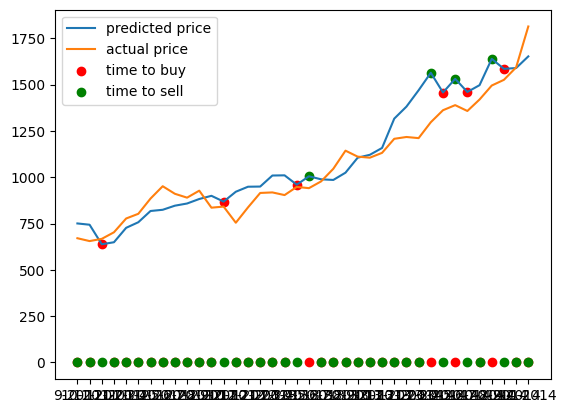

In [166]:
plt.plot(d_joined.predicted, label = "predicted price")
plt.plot(d_joined.actual, label = "actual price")

plt.scatter(d_joined.time, d_joined.buy_price, color = "red", label = "time to buy")
plt.scatter(d_joined.time, d_joined.sell_price, color = "green", label = "time to sell")
plt.legend(loc="upper left")
plt.plot()